In [127]:
# Importando as libraries

import pandas as pd
import json
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, MetaData, Table
from sqlalchemy.orm import declarative_base, sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
# Conectar ao PostgreSQL

USERNAME = "postgres"
PASSWORD = "041700"
HOST = "localhost"  # Ou endereço do servidor
PORT = "5432"
DATABASE = "indicadores_teste"

# Criando a engine do SQLAlchemy
try:
    engine = create_engine(
        f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}",
        connect_args={"options": "-c client_encoding=UTF8"}
    )
    print("✅ Engine criada com sucesso!")
except Exception as e:
    print(f"❌ Criação da Engine falhou: {e}")

# Listar as tabelas que queremos importar
tabelas = ["indicadores_utilidades", "indicadores_emprego"]

✅ Engine criada com sucesso!


In [129]:
# Criar um dicionário para armazenar os DataFrames
dataframes = {}

for tabela in tabelas:
    try:
        df = pd.read_sql_table(tabela, engine)
        
        # Converter a coluna 'data' para datetime
        if "data" in df.columns:
            df["data"] = pd.to_datetime(df["data"])
            df = df.sort_values("data")  # Garantir que esteja ordenado por data
        
        # Armazenar no dicionário
        dataframes[tabela] = df
        print(f"✅ Tabela '{tabela}' carregada com sucesso!")
    except Exception as e:
        print(f"⚠️ Erro ao carregar '{tabela}': {e}")

# Acesso direto aos DataFrames
df_utilidade = dataframes.get("indicadores_utilidades")
df_emprego = dataframes.get("indicadores_emprego")
df_rendimento = dataframes.get("indicadores_rendimento_habitual")

# Verificar os primeiros registros
for nome, df in dataframes.items():
    print(f"\n📌 {nome.upper()} - Amostra dos dados:")
    print(df.head())


✅ Tabela 'indicadores_utilidades' carregada com sucesso!
✅ Tabela 'indicadores_emprego' carregada com sucesso!

📌 INDICADORES_UTILIDADES - Amostra dos dados:
        data  pib_corrente  populacao  pib_per_capita
0 2015-01-01  5.995787e+12     202404           29623
1 2016-01-01  6.269328e+12     203872           30751
2 2017-01-01  6.585479e+12     205212           32091
3 2018-01-01  7.004141e+12     206529           33914
4 2019-01-01  7.389131e+12     207900           35542

📌 INDICADORES_EMPREGO - Amostra dos dados:
        data  ipca  salario_minimo  taxa_desocupacao  idade_trabalho  \
0 2015-01-01  1.24           788.0               6.9        159848.0   
1 2015-02-01  1.22           788.0               7.5        160018.0   
2 2015-03-01  1.32           788.0               8.0        160189.0   
3 2015-04-01  0.71           788.0               8.1        160354.0   
4 2015-05-01  0.74           788.0               8.3        160525.0   

   empregados_total  empregados_publico  

## Crescimento econômico e bem-estar da população

In [130]:
# Cálculo do IPCA acumulado nos últimos 12 meses
df_emprego['ipca_acumulado'] = df_emprego['ipca'].rolling(window=12).sum()

# Ajustando o salário mínimo pelo IPCA acumulado
df_emprego['salario_minimo_real'] = df_emprego['salario_minimo'] / (1 + df_emprego['ipca_acumulado'] / 100)

# Calcular a variação percentual real do salário mínimo mês a mês
df_emprego['salario_minimo_variacao_real'] = df_emprego['salario_minimo_real'].pct_change() * 100

C:\Users\marck\AppData\Local\Temp\ipykernel_38544\3369069806.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_emprego['salario_minimo_variacao_real'] = df_emprego['salario_minimo_real'].pct_change() * 100


In [131]:
# Criar a taxa de IPCA acumulada anual
df_emprego['ano'] = df_emprego['data'].dt.year
ipca_anual = df_emprego.groupby('ano')['ipca'].sum().reset_index()
ipca_anual.rename(columns={'ipca': 'ipca_acumulado'}, inplace=True)

# Criar a taxa de variação real do PIB e do PIB per capita
df_utilidade['ano'] = df_utilidade['data'].dt.year
df_utilidade = df_utilidade.merge(ipca_anual, on='ano', how='left')

# Ajustar PIB e PIB per capita pelo IPCA anual
df_utilidade['pib_real'] = df_utilidade['pib_corrente'] / (1 + df_utilidade['ipca_acumulado'] / 100)
df_utilidade['pib_per_capita_real'] = df_utilidade['pib_per_capita'] / (1 + df_utilidade['ipca_acumulado'] / 100)

# Calcular variação percentual real ano a ano
df_utilidade['pib_variacao_real'] = df_utilidade['pib_real'].pct_change() * 100
df_utilidade['pib_per_capita_variacao_real'] = df_utilidade['pib_per_capita_real'].pct_change() * 100

# Remover o primeiro ano, pois a variação percentual não pode ser calculada
df_utilidade.dropna(inplace=True)

df_emprego# Garantir que a coluna "data" está no formato datetime
df_emprego['data'] = pd.to_datetime(df_emprego['data'])
df_utilidade['data'] = pd.to_datetime(df_utilidade['data'])

# Definir "data" como índice
df_emprego.set_index('data', inplace=True)
df_utilidade.set_index('data', inplace=True)

# Ordenar os dados para evitar problemas com cálculos temporais
df_emprego.sort_index(inplace=True)
df_utilidade.sort_index(inplace=True)

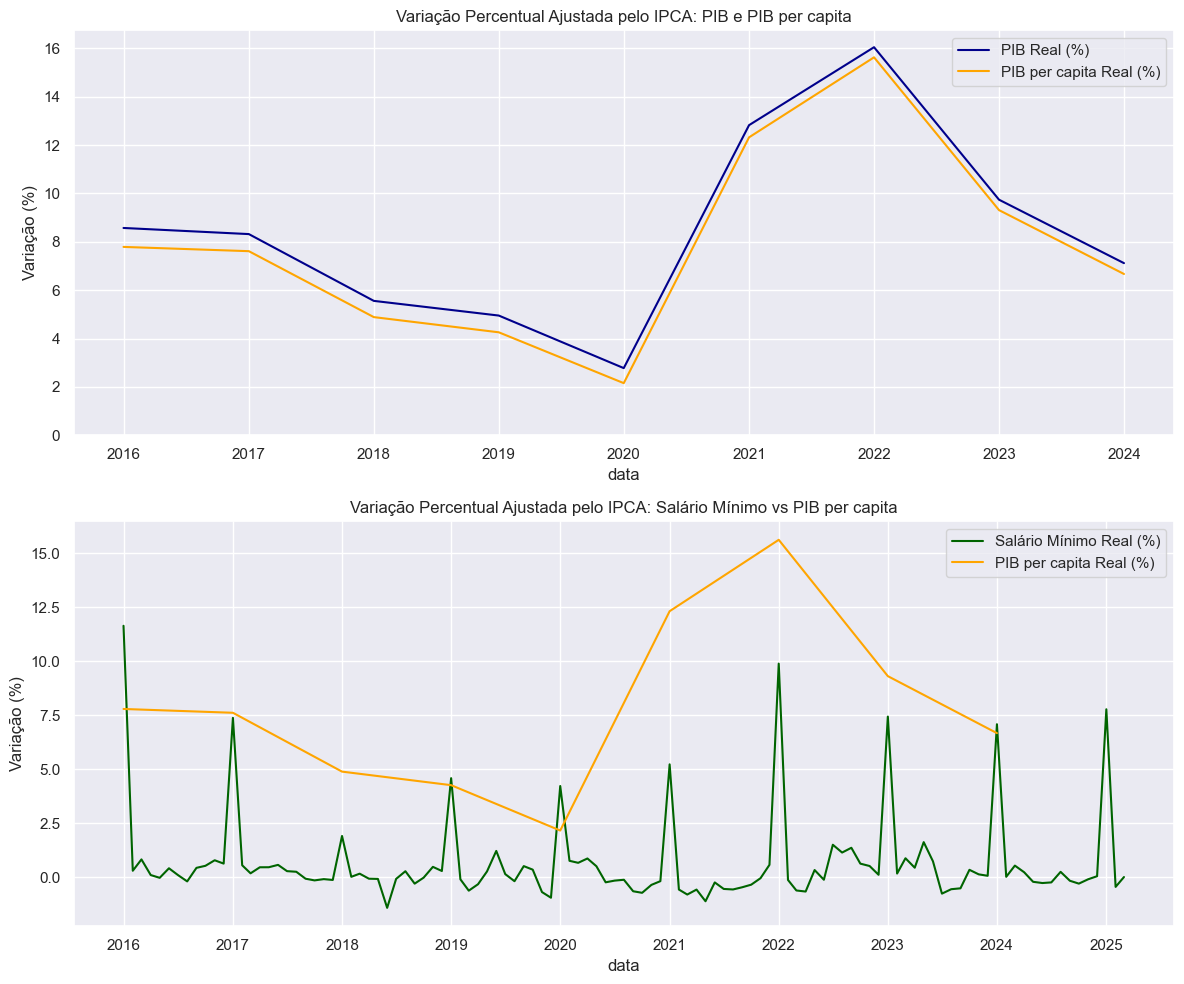

In [142]:
# Configuração do estilo
sns.set_theme(style="darkgrid")

# Criar figura e eixos
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

## 1. Variação percentual ajustada pelo IPCA: PIB, PIB per capita e População
sns.lineplot(data=df_utilidade, x=df_utilidade.index, y="pib_variacao_real", label="PIB Real (%)", ax=ax[0], c = "darkblue")
sns.lineplot(data=df_utilidade, x=df_utilidade.index, y="pib_per_capita_variacao_real", label="PIB per capita Real (%)", ax=ax[0], c = "orange")
ax[0].set_title("Variação Percentual Ajustada pelo IPCA: PIB e PIB per capita")
ax[0].set_ylabel("Variação (%)")
ax[0].legend()
ax[0].set_ylim(0)

## 2. Variação percentual ajustada pelo IPCA: Salário Mínimo vs PIB per capita
sns.lineplot(data=df_emprego, x=df_emprego.index, y="salario_minimo_variacao_real", label="Salário Mínimo Real (%)", ax=ax[1], c = "darkgreen")
sns.lineplot(data=df_utilidade, x=df_utilidade.index, y="pib_per_capita_variacao_real", label="PIB per capita Real (%)", ax=ax[1], c = "orange")
ax[1].set_title("Variação Percentual Ajustada pelo IPCA: Salário Mínimo vs PIB per capita")
ax[1].set_ylabel("Variação (%)")
ax[1].legend()

# Ajustar layout
plt.tight_layout()
plt.show()

## Mercado de Trabalho e Emprego

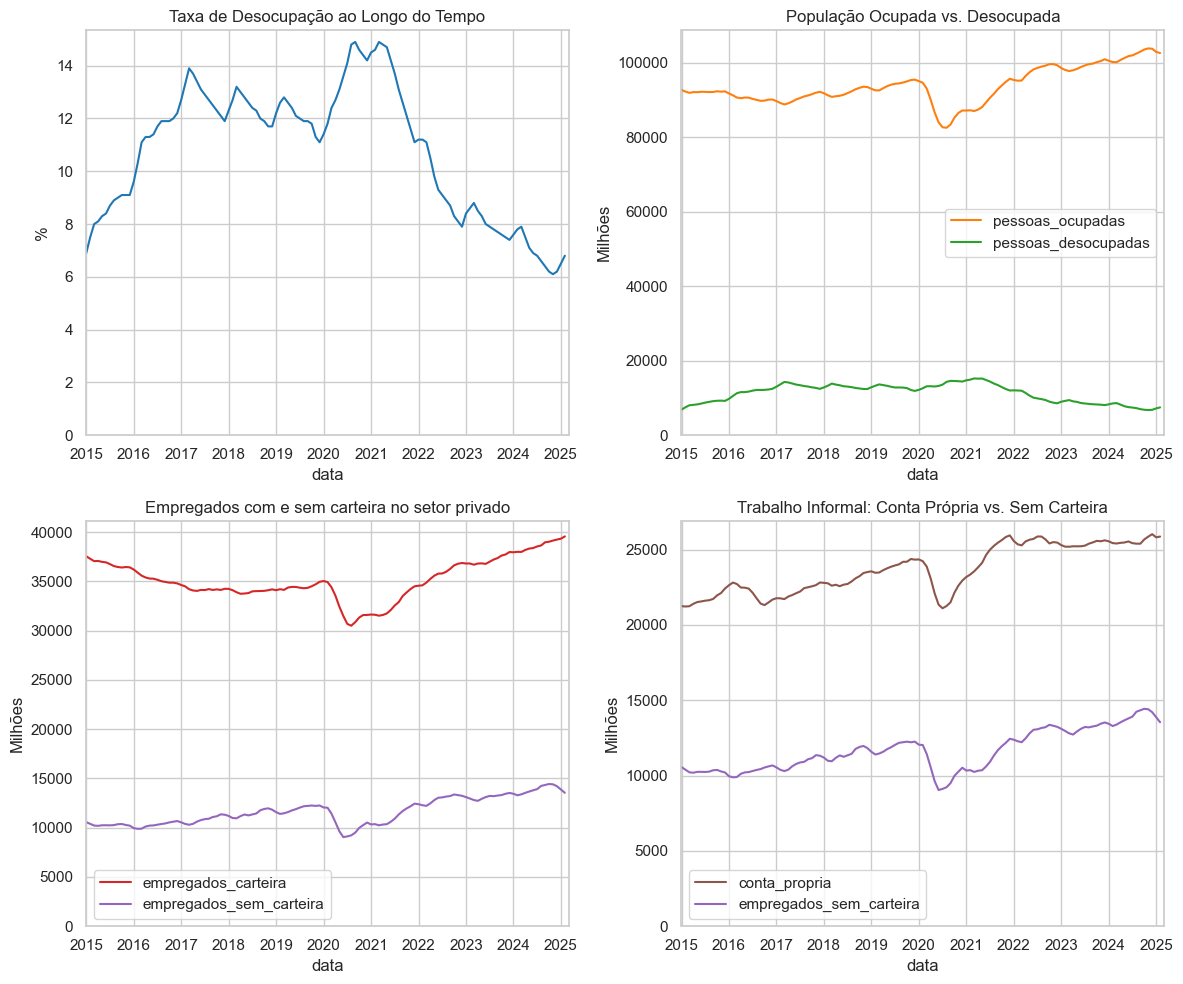

In [ ]:
# Configurações de estilo
sns.set_style("whitegrid")
cores = {
    "taxa_desocupacao": "#1f77b4",
    "pessoas_ocupadas": "#ff7f0e",
    "pessoas_desocupadas": "#2ca02c",
    "empregados_carteira": "#d62728",
    "empregados_sem_carteira": "#9467bd",  # Cor fixa para manter a consistência
    "conta_propria": "#8c564b",
}

# Criando os gráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Taxa de desocupação
df_emprego['taxa_desocupacao'].plot(ax=axes[0, 0], color=cores["taxa_desocupacao"])
axes[0, 0].set_title("Taxa de Desocupação ao Longo do Tempo")
axes[0, 0].set_ylabel("%")
axes[0, 0].set_ylim(0)

# População ocupada x desocupada
df_emprego[['pessoas_ocupadas', 'pessoas_desocupadas']].plot(
    ax=axes[0, 1], color=[cores["pessoas_ocupadas"], cores["pessoas_desocupadas"]]
)
axes[0, 1].set_title("População Ocupada vs. Desocupada")
axes[0, 1].set_ylabel("Milhões")
axes[0, 1].set_ylim(0)

# Empregados no setor privado (com carteira vs. sem carteira)
df_emprego[['empregados_carteira', 'empregados_sem_carteira']].plot(
    ax=axes[1, 0], color=[cores["empregados_carteira"], cores["empregados_sem_carteira"]]
)
axes[1, 0].set_title("Empregados com e sem carteira no setor privado")
axes[1, 0].set_ylabel("Milhões")
axes[1, 0].set_ylim(0)

# Trabalho informal: Conta própria e sem carteira
df_emprego[['conta_propria', 'empregados_sem_carteira']].plot(
    ax=axes[1, 1], color=[cores["conta_propria"], cores["empregados_sem_carteira"]]
)
axes[1, 1].set_title("Trabalho Informal: Conta Própria vs. Sem Carteira")
axes[1, 1].set_ylabel("Milhões")
axes[1, 1].set_ylim(0)

plt.tight_layout()
plt.show()

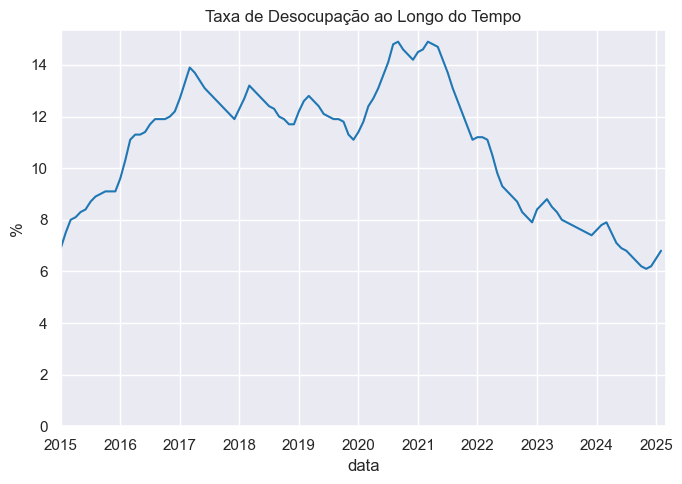

In [153]:
fig, ax = plt.subplots(figsize=(7, 5))

# Taxa de desocupação
df_emprego['taxa_desocupacao'].plot(ax=ax, color=cores["taxa_desocupacao"])
ax.set_title("Taxa de Desocupação ao Longo do Tempo")
ax.set_ylabel("%")
ax.set_ylim(0)


plt.tight_layout()
plt.show()

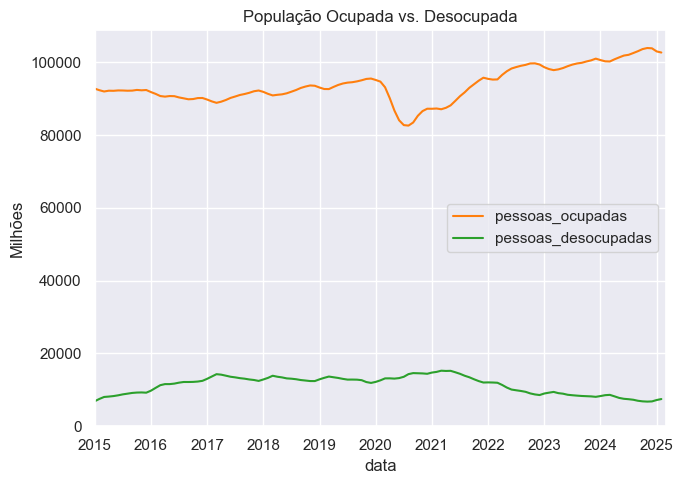

In [154]:
fig, ax = plt.subplots(figsize=(7, 5))

# População ocupada x desocupada
df_emprego[['pessoas_ocupadas', 'pessoas_desocupadas']].plot(
    ax=ax, color=[cores["pessoas_ocupadas"], cores["pessoas_desocupadas"]]
)
ax.set_title("População Ocupada vs. Desocupada")
ax.set_ylabel("Milhões")
ax.set_ylim(0)


plt.tight_layout()
plt.show()

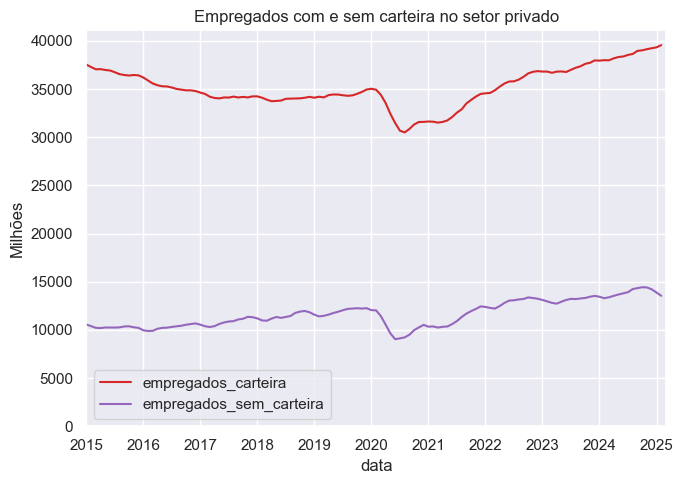

In [155]:
fig, ax = plt.subplots(figsize=(7, 5))

# Empregados no setor privado (com carteira vs. sem carteira)
df_emprego[['empregados_carteira', 'empregados_sem_carteira']].plot(
    ax=ax, color=[cores["empregados_carteira"], cores["empregados_sem_carteira"]]
)
ax.set_title("Empregados com e sem carteira no setor privado")
ax.set_ylabel("Milhões")
ax.set_ylim(0)


plt.tight_layout()
plt.show()

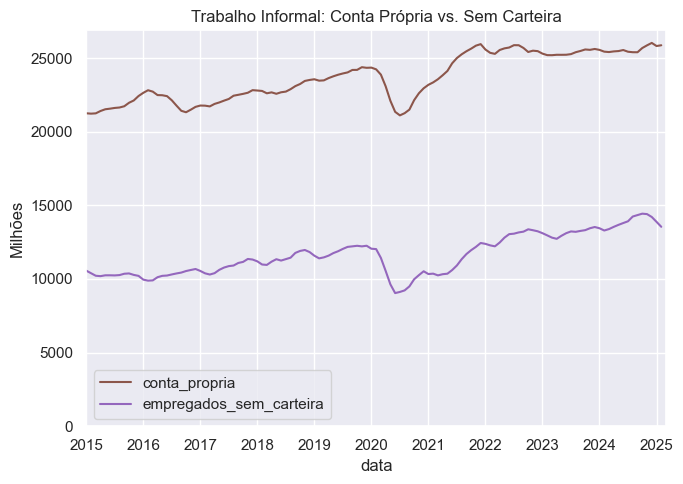

In [156]:
fig, ax = plt.subplots(figsize=(7, 5))

# Trabalho informal: Conta própria e sem carteira
df_emprego[['conta_propria', 'empregados_sem_carteira']].plot(
    ax=ax, color=[cores["conta_propria"], cores["empregados_sem_carteira"]]
)
ax.set_title("Trabalho Informal: Conta Própria vs. Sem Carteira")
ax.set_ylabel("Milhões")
ax.set_ylim(0)


plt.tight_layout()
plt.show()